# N+1 fish, N+2 fish Challenge

You are provided with video segments with one or many fish in each video segment. These videos are gathered on different boats in that are fishing for ground fish in the Gulf of Maine. The videos are collected from fixed-position cameras that are placed to look down on a ruler. A fish is placed on the ruler, the fisherman removes their hands from the ruler, and then either discards or keeps the fish based on the species and the size. The camera captures 5 frames per second.

Currently, these videos are manually reviewed for both scientific and compliance purposes. The ultimate goal of this competition is to create an algorithm that can identify the number and length of fish, and what species those fish are in the videos. This will significantly reduce the human review time for the videos and increase the volume of data to manage and protect fisheries.

Note: It is strictly prohibited to add additional annotations or hand-label the dataset. Algorithms must be created using the annotations as provided. Data augmentation that generates new videos and transforms the annotations is permitted.

## Preliminary Exploration

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from pandas.plotting import table
import skvideo.io
import cv2
import numpy as np
%matplotlib inline

In [3]:
df = pd.read_csv('../data/training.csv')

In [4]:
df[:10]

,row_id,video_id,frame,fish_number,length,x1,y1,x2,y2,species_fourspot,species_grey sole,species_other,species_plaice,species_summer,species_windowpane,species_winter
0,0,00WK7DR6FyPZ5u3A,0,1.0,165.3028,766.0,531.0,659.0,405.0,0,1,0,0,0,0,0
1,1,00WK7DR6FyPZ5u3A,18,2.0,176.5814,776.0,540.0,661.0,406.0,0,1,0,0,0,0,0
2,2,00WK7DR6FyPZ5u3A,41,3.0,172.4297,772.0,538.0,666.0,402.0,0,1,0,0,0,0,0
3,3,00WK7DR6FyPZ5u3A,63,4.0,166.6433,770.0,531.0,667.0,400.0,0,1,0,0,0,0,0
4,4,00WK7DR6FyPZ5u3A,82,5.0,177.8820,777.0,544.0,666.0,405.0,0,1,0,0,0,0,0
5,5,00WK7DR6FyPZ5u3A,100,6.0,161.4435,763.0,527.0,655.0,407.0,0,1,0,0,0,0,0
6,6,00WK7DR6FyPZ5u3A,115,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0
7,7,00WK7DR6FyPZ5u3A,123,7.0,181.6865,777.0,543.0,660.0,404.0,0,1,0,0,0,0,0
8,8,00WK7DR6FyPZ5u3A,142,8.0,206.4655,789.0,563.0,661.0,401.0,0,1,0,0,0,0,0
9,9,00WK7DR6FyPZ5u3A,160,9.0,197.0913,783.0,556.0,660.0,402.0,0,1,0,0,0,0,0


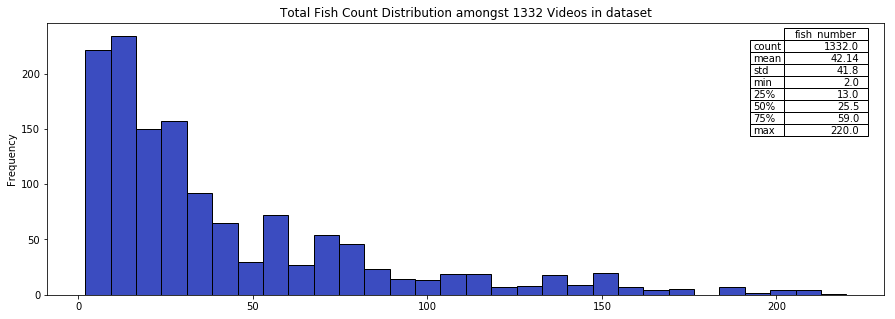

In [5]:
video_count = len(df.groupby('video_id'))
fishes_per_video_dist = df.groupby('video_id')['fish_number'].max()
with plt.style.context(('seaborn-muted')):
    fig, ax = plt.subplots(1, 1, figsize=(15,5))
    plt.title("Total Fish Count Distribution amongst {} Videos in dataset".format(video_count))
    table(ax, np.round(fishes_per_video_dist.describe(), 2), loc='upper right', colWidths=[0.1, 0.1, 0.1])
    fishes_per_video_dist.plot('hist',ax=ax,  bins=30, colormap='coolwarm', edgecolor='black')
    plt.show()

In [6]:
species_list = ['species_fourspot',
 'species_grey sole',
 'species_other',
 'species_plaice',
 'species_summer',
 'species_windowpane',
 'species_winter']

In [7]:
x = df[species_list].sum()

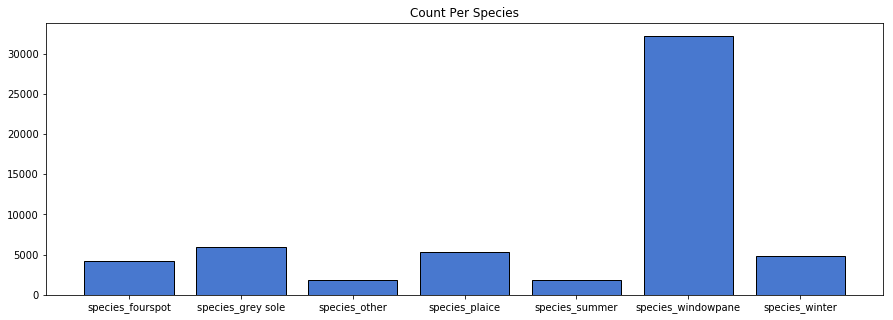

In [8]:
with plt.style.context(('seaborn-muted')):
    plt.figure(figsize=(15,5))
    plt.title("Count Per Species")
    plt.bar(range(len(x)), list(x), tick_label=list(x.index), edgecolor='black')
    plt.show()

Number of samples per species is highly imbalanced. The most common species in the dataset is the Windowpane Flounder occuring 32194 times and the rarest species are the Summer Flounder occuring 1808 times.
I will need to sample accordingly and ensure the sampling amongst the final dataset is balanced so that the classifier trains appropriately

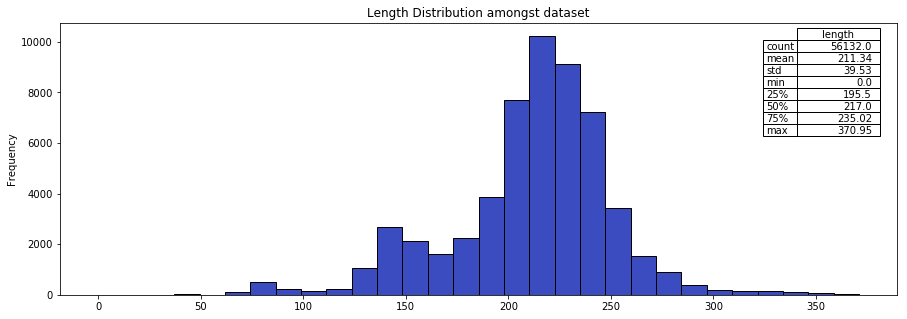

In [9]:
with plt.style.context(('seaborn-muted')):
    fig, ax = plt.subplots(1, 1, figsize=(15,5))
    plt.title("Length Distribution amongst dataset")
    table(ax, np.round(df['length'].describe(), 2), loc='upper right', colWidths=[0.1, 0.1, 0.1])
    df['length'].plot('hist',ax=ax,  bins=30, colormap='coolwarm', edgecolor='black')
    plt.show()

In [10]:
def plot_class(df, classname):
    subset = df[df[classname]==1]['length']
    with plt.style.context(('seaborn-muted')):
        fig, ax = plt.subplots(1, 1, figsize=(7,3))
        plt.title("Length Distribution amongst {}".format(classname))
        table(ax, np.round(subset.describe(), 2), loc='upper right', colWidths=[0.1, 0.1, 0.1])
        subset.plot('hist',ax=ax, bins=30 ,colormap='coolwarm', edgecolor='black')
        plt.show()

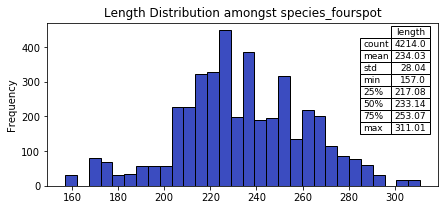

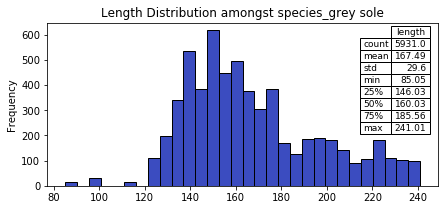

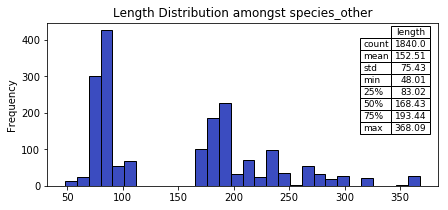

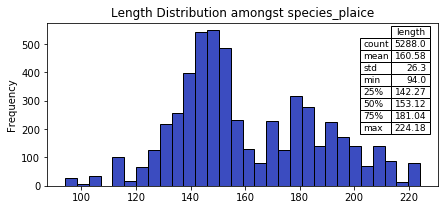

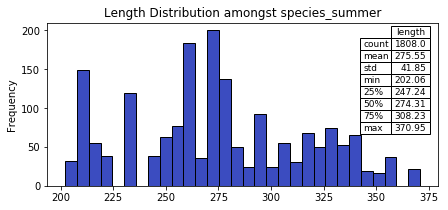

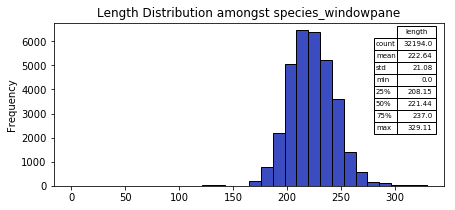

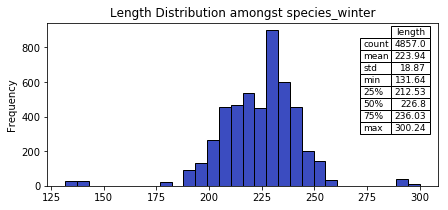

In [11]:
for sp in species_list:
    plot_class(df, sp)

In [12]:
base_path = "../data/train_videos/"
video_row = df[:1]
vid_file = video_row['video_id'][0] + '.mp4'
print(base_path+vid_file)

../data/train_videos/00WK7DR6FyPZ5u3A.mp4


In [71]:
vid = skvideo.io.vread(base_path+vid_file, num_frames=3)

In [72]:
video_row

,row_id,video_id,frame,fish_number,length,x1,y1,x2,y2,species_fourspot,species_grey sole,species_other,species_plaice,species_summer,species_windowpane,species_winter
0,0,00WK7DR6FyPZ5u3A,0,1.0,165.3028,766.0,531.0,659.0,405.0,0,1,0,0,0,0,0


(136, 117, 3)


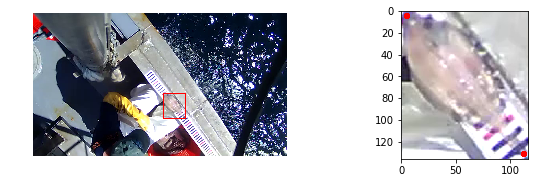

In [83]:
x1, x2, y1, y2 = map(int, video_row[['x1', 'x2', 'y1', 'y2']].as_matrix()[0])
bounding_pad = 5
if x1 > x2:
    box_x1 = x2 - bounding_pad
    box_x2 = x1 + bounding_pad
    if y1 > y2:
        box_y1 = y2 - bounding_pad
        box_y2 = y1 + bounding_pad
        corner="top_left"
        point_a = (bounding_pad, bounding_pad)
        point_b = (box_x2 -box_x1 - bounding_pad, box_y2-box_y1 - bounding_pad)
    else:
        box_y1 = y2 + bounding_pad
        box_y2 = y1 - bounding_pad
        corner="botton_left"
        point_a = (bounding_pad, box_y2-box_y1 - bounding_pad)
        point_b = (box_x2 -box_x1 - bounding_pad, bounding_pad)
else:
    box_x1 = x1 - bounding_pad
    box_x2 = x2 + bounding_pad
    if y1 > y2:
        box_y1 = y1 + bounding_pad
        box_y2 = y2 - bounding_pad
        corner="bottom_right"
        point_a = (box_x2 -box_x1 - bounding_pad, box_y2-box_y1 - bounding_pad)
        point_b = (bounding_pad, bounding_pad)
    else:
        box_y1 = y1 - bounding_pad
        box_y2 = y2 + bounding_pad
        corner="top_right"
        point_a = (box_x2 -box_x1 - bounding_pad, bounding_pad)
        point_b = (bounding_pad, box_y2-box_y1 - bounding_pad)
image = np.copy(vid[0])
image =cv2.rectangle(image, (x1,y1), (x2, y2), (255, 0, 0), 3)
cropped_image = np.copy(vid[0])[box_y1:box_y2,box_x1:box_x2]
print(cropped_image.shape)
cv2.circle(cropped_image, point_a, 1, (255,0,0), 2)
cv2.circle(cropped_image, point_b, 1, (255,0,0), 2)
figure = plt.figure(figsize = (10,6))
a = figure.add_subplot(2,2,1)
plt.imshow(image)
plt.axis('off')
a = figure.add_subplot(2,2,2)
plt.imshow(cropped_image)
plt.show()

In [84]:
import tqdm

ModuleNotFoundError: No module named 'tqdm'

In [50]:
x1

766